In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0

import seaborn as sns
sns.reset_orig()
import numpy as np
import random
import collections
import datetime
import time
from PIL import Image
from types import SimpleNamespace
import pandas as pd
import os
import nibabel as nib

import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, sampler

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

#setting device type
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import random
%matplotlib inline

In [4]:
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl

# Callbacks 
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

In [5]:
#can change this path to oasis2/
CHECKPOINT_PATH = '/content/drive/MyDrive/ColabNotebooks/finalProject'

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

In [6]:
model_dict = {}

def create_model(model_name, model_hparams):
    if model_name in model_dict:
        return model_dict[model_name](**model_hparams)
    else:
        assert False, f"Unknown model name \"{model_name}\". Available models are: {str(model_dict.keys())}"

act_fn_by_name = {
    "tanh": nn.Tanh,
    "relu": nn.ReLU,
    "leakyrelu": nn.LeakyReLU,
    "gelu": nn.GELU
}

#for model training
def train_model(model_name, save_name=None, **kwargs):
    """
    Inputs:
        model_name - Name of the model you want to run. Is used to look up the class in "model_dict"
        save_name (optional) - If specified, this name will be used for creating the checkpoint and logging directory.
    """
    if save_name is None:
        save_name = model_name
        
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),                          # Where to save models
                         gpus=1 if str(device)=="cuda:0" else 0,                                             # We run on a single GPU (if possible)
                         max_epochs=180,                                                                     # How many epochs to train for if no patience is set
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
                                    LearningRateMonitor("epoch")],                                           # Log learning rate every epoch
                         progress_bar_refresh_rate=1)                                                        # In case your notebook crashes due to the progress bar, consider increasing the refresh rate
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need
    
    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, save_name + ".ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = Oasis2Module.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(42) # To be reproducable
        model = Oasis2Module(model_name=model_name, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = Oasis2Module.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training
        
    # Test best model on validation and test set
    val_result = trainer.test(model, test_dataloaders=val_loader, verbose=False)
    test_result = trainer.test(model, test_dataloaders=test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}
    
    return model, result

In [7]:
class Oasis2Module(pl.LightningModule):

    def __init__(self, model_name, model_hparams, optimizer_name, optimizer_hparams):
        """
        Inputs:
            model_name - Name of the model/CNN to run. Used for creating the model (see function below)
            model_hparams - Hyperparameters for the model, as dictionary.
            optimizer_name - Name of the optimizer to use. Currently supported: Adam, SGD
            optimizer_hparams - Hyperparameters for the optimizer, as dictionary. This includes learning rate, weight decay, etc.
        """
        super().__init__()
        # Exports the hyperparameters to a YAML file, and create "self.hparams" namespace
        self.save_hyperparameters()
        # Create model
        self.model = create_model(model_name, model_hparams)
        # Create loss module
        self.loss_module = nn.CrossEntropyLoss()
        # Example input for visualizing the graph in Tensorboard
        self.example_input_array = torch.zeros((1, 3, 32, 32), dtype=torch.float32)

    def forward(self, imgs):
        # Forward function that is run when visualizing the graph
        return self.model(imgs)

    def configure_optimizers(self):
        # We will support Adam or SGD as optimizers.
        if self.hparams.optimizer_name == "Adam":
            # AdamW is Adam with a correct implementation of weight decay (see here for details: https://arxiv.org/pdf/1711.05101.pdf)
            optimizer = optim.AdamW(
                self.parameters(), **self.hparams.optimizer_hparams)
        elif self.hparams.optimizer_name == "SGD":
            optimizer = optim.SGD(self.parameters(), **self.hparams.optimizer_hparams)
        else:
            assert False, f"Unknown optimizer: \"{self.hparams.optimizer_name}\""

        # We will reduce the learning rate by 0.1 after 100 and 150 epochs
        scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[100, 150], gamma=0.1)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        # "batch" is the output of the training data loader.
        imgs, labels = batch
        preds = self.model(imgs)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Logs the accuracy per epoch to tensorboard (weighted average over batches)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss)
        return loss  # Return tensor to call ".backward" on

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches)
        self.log('val_acc', acc)

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches), and returns it afterwards
        self.log('test_acc', acc)

In [8]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

In [9]:
test_load = nib.load('/content/drive/MyDrive/OASIS2/OAS2_RAW_PART1/OAS2_0001_MR1/RAW/mpr-1.nifti.img').get_fdata()
test_load.shape

(256, 256, 128, 1)

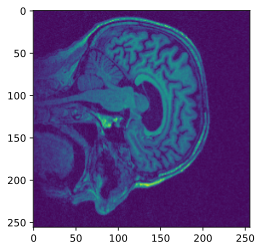

In [10]:
test = test_load[:,:,59].squeeze()
plt.imshow(test)
plt.show()

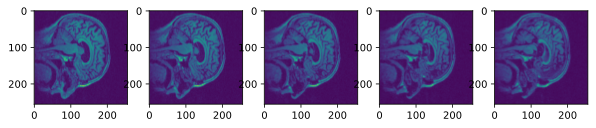

In [11]:
for i in range(5):
    plt.subplot(5, 5,i + 1)
    plt.imshow((test_load[:,:,59 + i].squeeze()))
    plt.gcf().set_size_inches(10, 10)
plt.show()


In [10]:
import torch

from torchvision import transforms

from PIL import Image

convert_tensor = transforms.ToTensor()

tens = convert_tensor(test_load.squeeze())
tens.size()

torch.Size([128, 256, 256])

In [11]:
tens

tensor([[[ 33., 167.,  ..., 197., 139.],
         [160., 164.,  ..., 107., 147.],
         ...,
         [ 88., 155.,  ...,  20., 152.],
         [ 89., 164.,  ..., 117.,  50.]],

        [[117., 156.,  ..., 137.,  93.],
         [215., 112.,  ...,  99., 221.],
         ...,
         [126., 159.,  ..., 110., 278.],
         [ 47., 198.,  ...,  80.,  70.]],

        ...,

        [[111., 176.,  ..., 247., 201.],
         [111., 150.,  ...,  56., 131.],
         ...,
         [171., 209.,  ..., 365.,  92.],
         [ 36.,  82.,  ...,  87., 131.]],

        [[128., 234.,  ...,  79., 194.],
         [ 67.,  43.,  ..., 163.,  62.],
         ...,
         [ 95., 103.,  ...,  23., 194.],
         [ 34., 253.,  ..., 199., 140.]]], dtype=torch.float64)

In [12]:
import glob
for filename in glob.glob("/content/drive/MyDrive/OASIS2/OAS2_RAW_PART1/OAS2_0001_MR1" + '/*.img', recursive=True):
  test_load = nib.load(filename)
  test = test_load[:,:,59].squeeze()
  plt.imshow(test)
  plt.show()

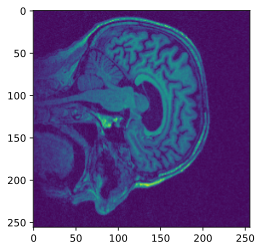

In [15]:
test_load = nib.load('/content/drive/MyDrive/OASIS2/OAS2_RAW_PART1/OAS2_0001_MR1/RAW/mpr-1.nifti.img').get_fdata()
test = test_load[:,:,59].squeeze()
plt.imshow(test)
plt.show()



In [16]:
for i in range(128):
    plt.subplot(256, 256, i + 1)
    plt.imshow((test_load[:,:,i].squeeze()))
    plt.gcf().set_size_inches(400, 400)
plt.show()

In [ ]:
import glob
import shutil
import os
RootDir1 = r'/content/drive/MyDrive/OASIS2/OAS2_RAW_PART1'
os.listdir(RootDir1)

In [14]:
mean = torch.load("/content/drive/MyDrive/OASIS2/OAS2_RAW_PART1/mean_t.pt")
std = torch.load( "/content/drive/MyDrive/OASIS2/OAS2_RAW_PART1/std_t.pt")
mean.reshape(256,256,128)
mean.size()

torch.Size([1, 256, 256, 128])

In [15]:
test_load = nib.load('/content/drive/MyDrive/OASIS2/OAS2_RAW_PART1/OAS2_0001_MR1/RAW/mpr-1.nifti.img').get_fdata()
test_load.shape
img = torch.from_numpy(test_load)
torch.reshape(img, (-1,)).size()

torch.Size([8388608])

In [20]:
import pandas as pd
my_dataframe = pd.read_csv("/content/drive/MyDrive/OASIS2/OAS2_RAW_PART1/Oasis_Demo_2 - Oasis_Demo.csv")

from torch.utils.data import Dataset
from PIL import Image
from torchvision import models, transforms
import cv2

class createDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.transform = transforms.Compose([ transforms.RandomHorizontalFlip()])

    def __getitem__(self, index):
        image = self.dataframe.iloc[index, 0]
        image = nib.load(image).get_fdata()  
        image = torch.from_numpy(np.asarray(image))
        image = image.squeeze()
        image = image.reshape(1,256,256, 128)

        image = self.transform(image)
        image = image.double()
        image = image.squeeze()

        label = self.dataframe.iloc[index, 1]
        label = torch.Tensor(label)
        return image, label

    def __len__(self):
        return self.dataframe.shape[0]
        
      
my_dataset = createDataset(dataframe = my_dataframe)

from torch.utils.data import DataLoader

my_dataloader = DataLoader(dataset = my_dataset)

In [16]:
import pandas as pd
my_dataframe = pd.read_csv("/content/drive/MyDrive/OASIS2/OAS2_RAW_PART1/Oasis_Demo_2 - Oasis_Demo.csv")

from torch.utils.data import Dataset
from PIL import Image
from torchvision import models, transforms
import cv2

class createDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.transform = transforms.Compose([transforms.Normalize(torch.reshape(mean,(256,256,128,1)), torch.reshape(std,(256,256,128,1))), transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip()])

    def __getitem__(self, index):
        image = self.dataframe.iloc[index, 0]
        image = nib.load(image).get_fdata()  
        image = torch.from_numpy(np.asarray(image))
        image = image.double()
        image = self.transform(image)
        #image = image.squeeze()
        image = image.double()

        label = self.dataframe.iloc[index, 1]
        label = torch.from_numpy(np.array(label, dtype='int32'))
        return image, label

    def __len__(self):
        return self.dataframe.shape[0]
        
      
my_dataset = createDataset(dataframe = my_dataframe)

from torch.utils.data import DataLoader

my_dataloader = DataLoader(dataset = my_dataset, batch_size=3, shuffle = True)

In [17]:
#setting up densenet modules
class DenseLayer(nn.Module):
    
    def __init__(self, c_in, bn_size, growth_rate, act_fn, drop_rate):
        """
        Inputs:
            c_in - Number of input channels
            bn_size - Bottleneck size (factor of growth rate) for the output of the 1x1 convolution. Typically between 2 and 4.
            growth_rate - Number of output channels of the 3x3 convolution
            act_fn - Activation class constructor (e.g. nn.ReLU)
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(), #relu
            nn.Conv2d(c_in, bn_size * growth_rate, kernel_size=1, bias=False),
            nn.BatchNorm2d(bn_size * growth_rate),
            act_fn(), #relu
            nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False),
            nn.Dropout2d(p=drop_rate)
        )
        
    def forward(self, x):
      out = self.net(x)
      out = torch.cat([out, x], dim=1)
      return out

class DenseBlock(nn.Module):
    
    def __init__(self, c_in, num_layers, bn_size, growth_rate, act_fn, drop_rate):
        """
        Inputs:
            c_in - Number of input channels
            num_layers - Number of dense layers to apply in the block
            bn_size - Bottleneck size to use in the dense layers
            growth_rate - Growth rate to use in the dense layers
            act_fn - Activation function to use in the dense layers
        """
        super().__init__()
        layers = []
        for layer_idx in range(num_layers):
            layers.append(
                DenseLayer(c_in=c_in + layer_idx * growth_rate, # Input channels are original plus the feature maps from previous layers
                           bn_size=bn_size,
                           growth_rate=growth_rate,
                           act_fn=act_fn,
                           drop_rate=drop_rate)
            )
        self.block = nn.Sequential(*layers)
        
    def forward(self, x):
        out = self.block(x)
        return out

class TransitionLayer(nn.Module):
    
    def __init__(self, c_in, c_out, act_fn):
        super().__init__()
        self.transition = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(), #relu
            nn.Conv2d(c_in, c_out, kernel_size=1, stride=1, bias=False),
            nn.AvgPool2d(kernel_size=2, stride=2) 
        )
        
    def forward(self, x):
        return self.transition(x)

In [18]:
class DenseNet(nn.Module):
    
    def __init__(self, num_classes=3, num_layers=[6,12,24,16], bn_size=4, growth_rate=16, act_fn_name="relu", num_init_features=64,drop_rate=0.3, **kwargs):
        super().__init__()
        self.hparams = SimpleNamespace(num_classes=num_classes,
                                       num_layers=num_layers,
                                       bn_size=bn_size,
                                       growth_rate=growth_rate,
                                       act_fn_name=act_fn_name,
                                       act_fn=act_fn_by_name[act_fn_name],
                                       num_init_features=num_init_features,
                                       drop_rate=drop_rate)
        self._create_network()
        self._init_params()
        
    def _create_network(self):
        c_hidden = self.hparams.growth_rate * self.hparams.bn_size # The start number of hidden channels
        
        # A first convolution on the original image to scale up the channel size
        self.input_net = nn.Sequential(
            nn.Conv2d(256, c_hidden, kernel_size=3, padding=1) # No batch norm or activation function as done inside the Dense layers
        )
        
        # Creating the dense blocks, eventually including transition layers
        blocks = []
        num_features=self.hparams.num_init_features
        for block_idx, num_layers in enumerate(self.hparams.num_layers):
            blocks.append( 
                DenseBlock(c_in=c_hidden, 
                           num_layers=num_layers, 
                           bn_size=self.hparams.bn_size,
                           growth_rate=self.hparams.growth_rate,
                           act_fn=self.hparams.act_fn,
                           drop_rate=self.hparams.drop_rate
                           )
            )
            c_hidden = c_hidden + num_layers * self.hparams.growth_rate # Overall output of the dense block
            if block_idx < len(self.hparams.num_layers)-1: # Don't apply transition layer on last block
                blocks.append(
                    TransitionLayer(c_in=c_hidden,
                                    c_out=c_hidden // 2,
                                    act_fn=self.hparams.act_fn))
                c_hidden = c_hidden // 2
                
        self.blocks = nn.Sequential(*blocks)
        
        # Mapping to classification output
        self.output_net = nn.Sequential(
            nn.BatchNorm2d(c_hidden),
            self.hparams.act_fn(),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(c_hidden, self.hparams.num_classes)
        )

    def _init_params(self):
        # Based on our discussion in Tutorial 4, we should initialize the convolutions according to the activation function
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity=self.hparams.act_fn_name)
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.blocks(x)
        x = self.output_net(x)
        return x

In [19]:
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms
import torchvision.datasets as dsets
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [20]:
model = DenseNet().double()
print(model)

DenseNet(
  (input_net): Sequential(
    (0): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (blocks): Sequential(
    (0): DenseBlock(
      (block): Sequential(
        (0): DenseLayer(
          (net): Sequential(
            (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU()
            (2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (4): ReLU()
            (5): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (6): Dropout2d(p=0.3, inplace=False)
          )
        )
        (1): DenseLayer(
          (net): Sequential(
            (0): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU()
            (2): Conv2d(80, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (3):

In [21]:
numel_list = [p.numel() for p in model.parameters()]
print(sum(numel_list))
print(numel_list)

1961351
[147456, 64, 64, 64, 4096, 64, 64, 9216, 80, 80, 5120, 64, 64, 9216, 96, 96, 6144, 64, 64, 9216, 112, 112, 7168, 64, 64, 9216, 128, 128, 8192, 64, 64, 9216, 144, 144, 9216, 64, 64, 9216, 160, 160, 12800, 80, 80, 5120, 64, 64, 9216, 96, 96, 6144, 64, 64, 9216, 112, 112, 7168, 64, 64, 9216, 128, 128, 8192, 64, 64, 9216, 144, 144, 9216, 64, 64, 9216, 160, 160, 10240, 64, 64, 9216, 176, 176, 11264, 64, 64, 9216, 192, 192, 12288, 64, 64, 9216, 208, 208, 13312, 64, 64, 9216, 224, 224, 14336, 64, 64, 9216, 240, 240, 15360, 64, 64, 9216, 256, 256, 16384, 64, 64, 9216, 272, 272, 36992, 136, 136, 8704, 64, 64, 9216, 152, 152, 9728, 64, 64, 9216, 168, 168, 10752, 64, 64, 9216, 184, 184, 11776, 64, 64, 9216, 200, 200, 12800, 64, 64, 9216, 216, 216, 13824, 64, 64, 9216, 232, 232, 14848, 64, 64, 9216, 248, 248, 15872, 64, 64, 9216, 264, 264, 16896, 64, 64, 9216, 280, 280, 17920, 64, 64, 9216, 296, 296, 18944, 64, 64, 9216, 312, 312, 19968, 64, 64, 9216, 328, 328, 20992, 64, 64, 9216, 344, 34

In [24]:
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr= 1e-3, momentum = 0.9)
num_epochs = 2

In [ ]:
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
training_start_time = time.time()
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(my_dataloader):
        images, labels = images.cuda(), labels.cuda()
        
        train = Variable(images).to(device)
        labels = Variable(labels).to(device)
        # Clear gradients
        optimizer.zero_grad()
        # Forward propagation
        train = train.squeeze()
        outputs = model(train)
        # Calculate softmax and ross entropy loss
        loss = criterion(outputs, labels.long())
        # Calculating gradients
        loss.backward()
        # Update parameters
        optimizer.step()
        
        count += 1
        if count % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in my_dataloader:
                images, labels = images.cuda(), labels.cuda()
                
                test = Variable(images)
                test = test.squeeze()
                # Forward propagation
                outputs = model(test)

                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))
print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))

Iteration: 500  Loss: 0.7556034997509764  Accuracy: 44.696414947509766 %


*   6h 9m 4:54 Iteration: 500  Loss: 0.7556034997509764  Accuracy: 44.696414947509766 %
*   6h 33m 5:19
6h 52m 5:37
7h 11m 5:56
i think it ran out of GPU

